In [1]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd

def visualize(**images):
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

def round(temp):
    return np.round((temp - np.min(temp))/((np.max(temp) - np.min(temp))))

def yasai_show_v2(dataset, idx, model=None):
    image, mask = dataset[idx]
    if model is not None:
        pred = model(image.unsqueeze(0))
        with torch.no_grad():
            pred = np.asarray(pred).squeeze()
    with torch.no_grad():
        image = np.asarray(image).transpose(1, 2, 0)
        mask = np.asarray(mask)

    if model is not None:
        tempdict = {}
        tempdict['image'] = image
        for i in range(pred.shape[0]):
            tempdict['pred_' + str(i)] = 0.4 * round(pred[i]) + 0.6 * image[...,0].squeeze()
        visualize(**tempdict)

    if model is not None:
        tempdict = {}
        tempdict['image'] = image
        for i in range(pred.shape[0]):
            tempdict['pred_' + str(i)] = pred[i]
        visualize(**tempdict)

    tempdict = {}
    tempdict['image'] = image
    for i in range(mask.shape[0]):
        tempdict['mask_' + str(i)] = 0.4 * round(mask[i]) + 0.6 * image[...,0].squeeze()
    visualize(**tempdict)

def yasai_model_save_v1(model, text=''):
    temp = os.path.join(os.getcwd(), 'model_' + text + datetime.now().strftime("%y%m%d%H%M.pt"))
    torch.save({'state_dict': model.state_dict(), 'model': model}, temp)
    print('Successfully saved to ' + temp)

def yasai_model_load_v1(path):
    temp = torch.load(path)
    model = temp['model']
    model.load_state_dict(temp['state_dict'])
    print('Successfully loaded from ' + path)
    return model

def yasai_compute_iou_v1(pred, label):
    # print(label.shape, np.unique(label))
    # print(round(pred).shape, np.unique(round(pred)))
    label_c = label == 1
    pred_c = round(pred) == 1

    intersection = np.logical_and(pred_c, label_c).sum()
    union = np.logical_or(pred_c, label_c).sum()

    if union != 0 and np.sum(label_c) != 0:
        return intersection / union
    
def yasai_compute_batch_iou_v1(model, data_loader):
    ious = []
    for image, mask in tqdm(data_loader, desc='Iterating'):
        pred = model(image)
        with torch.no_grad():
            pred = np.asarray(pred).squeeze()
            mask = np.asarray(mask)
        ious += [yasai_compute_iou_v1(pred, mask)]
    print(sum(ious)/len(ious))

def yasai_get_path_df_v1(img_path, mask_path):
    images, masks = [], []

    i = 0

    for get_img_name in os.listdir(img_path):
        images += [os.path.join(img_path, get_img_name)] # NORMAL_G1_Lid1_LRid293_Gid3133_Bl30.png
        masks += [os.path.join(mask_path, get_img_name.replace(get_img_name.split('_')[-1], 'C4.png'))] # NORMAL_G1_Lid1_LRid293_Gid3133_C4.png
        
        i = i+1

    PathDF = pd.DataFrame({'images': images, 'masks': masks})
    print(i)
    PathDF.head()
    return PathDF

def yasai_model_checker_v1(model, tenser, dataloader=None, device='cuda'):
    model = model.to(device)
    t = torch.randn(tenser).to(device)
    print('give_model', t.shape)
    get = model(t)
    print('got_from_model', get.shape)
    if dataloader is not None:
        for data, label in dataloader:
            print()
            print('data_shape', data.shape)
            print('label_shape', label.shape)
            break

## Import

In [2]:
import torchvision
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import os
import pandas as pd
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch import optim
from PIL import Image
import torch.nn.functional as F
import cv2
# from sklearn.model_selection import train_test_split

%matplotlib inline

## Root

In [3]:
ROOT_PATH = '/home/yasaisen/Desktop/09_research/09_research_main/lab_03'

In [4]:
dataset_folder = 'dataset_C_v_2.9.3'

train_img_path = os.path.join(ROOT_PATH, dataset_folder, 'train_for_base_imgs')
train_mask_path = os.path.join(ROOT_PATH, dataset_folder, 'train_for_base_mask')

valid_img_path = os.path.join(ROOT_PATH, dataset_folder, 'valid_imgs')
valid_mask_path = os.path.join(ROOT_PATH, dataset_folder, 'valid_mask')

test_img_path = os.path.join(ROOT_PATH, dataset_folder, 'test_imgs')
test_mask_path = os.path.join(ROOT_PATH, dataset_folder, 'test_mask')

## Aug

In [5]:
img_size = 224
train_bsz = 4
device = 'cuda'
epochs = 30
valid_bsz = 8
test_bsz = 8

## Dataset

In [6]:
train_df = yasai_get_path_df_v1(train_img_path, train_mask_path)
valid_df = yasai_get_path_df_v1(valid_img_path, valid_mask_path)
test_df = yasai_get_path_df_v1(test_img_path, test_mask_path)

11313
1037
917


In [7]:
def plot_example(idx, df):
    image_path = df['images'].iloc[idx]
    mask_path = df['masks'].iloc[idx]
    image = Image.open(image_path)#.convert('RGB')
    mask = Image.open(mask_path)#.convert('RGB')
    
    fig, ax = plt.subplots(1, 3, figsize=(8,4))
    ax[0].imshow(np.array(image).astype(np.uint8))
    ax[0].set_title("Image")
    ax[1].imshow(np.array(mask).astype(np.uint8))
    ax[1].set_title("Mask")
    img = np.array(image) * 0.3 + np.array(mask) * 0.7
    img = img.astype(np.uint8)
    ax[2].imshow(img)
    ax[2].set_title('')
    plt.show()

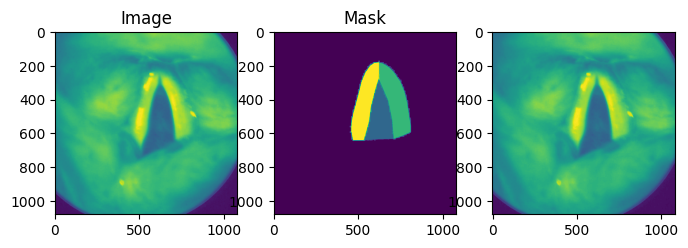

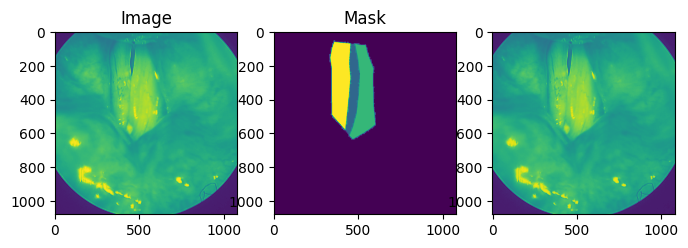

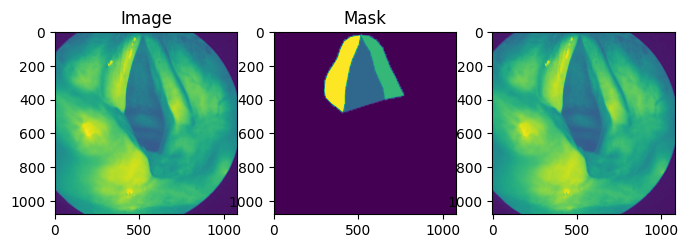

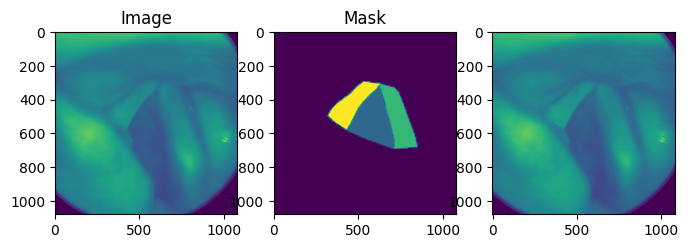

In [8]:
plot_example(0, train_df)
plot_example(50, valid_df)
plot_example(88, test_df)
plot_example(190, train_df)

In [9]:
transform = transforms.Compose([
            transforms.ToTensor()
            ])

In [10]:
# mask_path = '/home/yasaisen/Desktop/09_research/09_research_main/lab_03/dataset_C_v_2.9.3/train_for_base_mask/RSLN_L_G10_Lid45_LRid112_Gid7024_C4.png'
# label = Image.open(mask_path)
# label = np.array(label)

In [11]:
class mod_Dataset(Dataset):
    def __init__(self, path_df, transform=None):
        self.path_df = path_df
        self.transform = transform

    def __len__(self):
        return self.path_df.shape[0]
    
    def __getitem__(self, idx):
        if self.transform is not None:
            trans_Resize = transforms.Resize(224)

            images = trans_Resize(Image.open(self.path_df.iloc[idx]['images']).convert('RGB'))
            images = self.transform(images)

            mask = trans_Resize(Image.open(self.path_df.iloc[idx]['masks']))
            mask = np.array(mask)
            masks = np.zeros([np.max(np.unique(mask))+1, mask.shape[0], mask.shape[1]])
            for i in range(mask.shape[0]):
                for j in range(mask.shape[1]):
                    masks[mask[i][j]][i][j] = 1

            masks = torch.from_numpy(masks)
            masks = masks.type(torch.float32)

        return images, masks

In [12]:
train_data = mod_Dataset(train_df, transform)
valid_data = mod_Dataset(valid_df, transform)
test_data  = mod_Dataset(test_df, transform)

train_loader = DataLoader(train_data, batch_size=train_bsz, shuffle=True , num_workers=0, pin_memory=True, drop_last=True)
valid_loader = DataLoader(valid_data, batch_size=valid_bsz, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_data , batch_size=test_bsz , shuffle=False, num_workers=0)

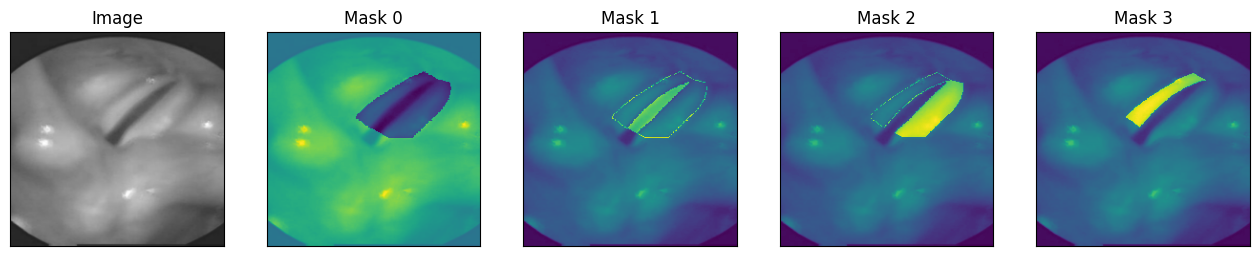

In [13]:
yasai_show_v2(train_data, 1)

## Model

In [14]:
class Block(nn.Module):
    def __init__(self, inChannels, outChannels):
        super().__init__()
        # store the convolution and RELU layers
        self.conv1 = nn.Conv2d(inChannels, outChannels, 3)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(outChannels, outChannels, 3)
    def forward(self, x):
        # apply CONV => RELU => CONV block to the inputs and return it
        return self.conv2(self.relu(self.conv1(x)))

In [15]:
class Encoder(nn.Module):
    def __init__(self, channels=(3, 16, 32, 64)):
        super().__init__()
        # store the encoder blocks and maxpooling layer
        self.encBlocks = nn.ModuleList(
            [Block(channels[i], channels[i + 1])
                for i in range(len(channels) - 1)])
        self.pool = nn.MaxPool2d(2)
    def forward(self, x):
        # initialize an empty list to store the intermediate outputs
        blockOutputs = []
        # loop through the encoder blocks
        for block in self.encBlocks:
            # pass the inputs through the current encoder block, store
            # the outputs, and then apply maxpooling on the output
            x = block(x)
            blockOutputs.append(x)
            x = self.pool(x)
        # return the list containing the intermediate outputs
        return blockOutputs

In [16]:
class Decoder(nn.Module):
    def __init__(self, channels=(64, 32, 16)):
        super().__init__()
        # initialize the number of channels, upsampler blocks, and
        # decoder blocks
        self.channels = channels
        self.upconvs = nn.ModuleList(
            [nn.ConvTranspose2d(channels[i], channels[i + 1], 2, 2)
                for i in range(len(channels) - 1)])
        self.dec_blocks = nn.ModuleList(
            [Block(channels[i], channels[i + 1])
                for i in range(len(channels) - 1)])
    def forward(self, x, encFeatures):
        # loop through the number of channels
        for i in range(len(self.channels) - 1):
            # pass the inputs through the upsampler blocks
            x = self.upconvs[i](x)
            # crop the current features from the encoder blocks,
            # concatenate them with the current upsampled features,
            # and pass the concatenated output through the current
            # decoder block
            encFeat = self.crop(encFeatures[i], x)
            x = torch.cat([x, encFeat], dim=1)
            x = self.dec_blocks[i](x)
        # return the final decoder output
        return x
    def crop(self, encFeatures, x):
        # grab the dimensions of the inputs, and crop the encoder
        # features to match the dimensions
        (_, _, H, W) = x.shape
        encFeatures = transforms.CenterCrop([H, W])(encFeatures)
        # return the cropped features
        return encFeatures

In [17]:
class UNet(nn.Module):
    def __init__(self, encChannels=(3, 16, 32, 64), decChannels=(64, 32, 16), nbClasses=1, retainDim=True, outSize=(img_size,  img_size)):
        super().__init__()
        self.encoder = Encoder(encChannels)
        self.decoder = Decoder(decChannels)
        self.head = nn.Conv2d(decChannels[-1], nbClasses, 1)
        self.retainDim = retainDim
        self.outSize = outSize
        
    def forward(self, x):
        # grab the features from the encoder
        encFeatures = self.encoder(x)
        # pass the encoder features through decoder making sure that
        # their dimensions are suited for concatenation
        decFeatures = self.decoder(encFeatures[::-1][0],
            encFeatures[::-1][1:])
        # pass the decoder features through the regression head to
        # obtain the segmentation mask
        map = self.head(decFeatures)
        # check to see if we are retaining the original output
        # dimensions and if so, then resize the output to match them
        if self.retainDim:
            map = F.interpolate(map, self.outSize)
        # return the segmentation map
        return torch.softmax(map,dim=1)

In [18]:
model = UNet(nbClasses=4).to(device)

In [19]:
yasai_model_checker_v1(model, (4, 3, 224, 224), train_loader)

give_model torch.Size([4, 3, 224, 224])
got_from_model torch.Size([4, 4, 224, 224])

data_shape torch.Size([4, 3, 224, 224])
label_shape torch.Size([4, 4, 224, 224])


## Train

In [20]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=False, reduction=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduction = reduction

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduction:
            return torch.mean(F_loss)
        else:
            return F_loss

In [21]:
def dice_coef_metric(pred, label):
    intersection = 2.0 * (pred * label).sum()
    union = pred.sum() + label.sum()
    if pred.sum() == 0 and label.sum() == 0:
        return 1
    return intersection / union

In [28]:
def train_loop(model, optimizer, criterion, train_loader, device=device):
    running_loss = 0
    model.train()
    pbar = tqdm(train_loader, desc='Iterating over train data')

    final_dice_coef = 0 
    
    for imgs, masks in pbar:
        # pass to device

        # print(type(imgs), imgs.shape)
        # print(type(masks), masks.shape)

        imgs = imgs.to(device)
        masks = masks.to(device)

        # forward
        out = model(imgs)
        # with torch.no_grad():
        #     print(np.sum(np.asarray(out.cpu()), axis=1))

        loss = criterion(out, masks)
        running_loss += loss.item() * imgs.shape[0]
#         print(loss.item())
        
        out_cut = np.copy(out.detach().cpu().numpy())
        out_cut[np.nonzero(out_cut < 0.5)] = 0.0
        out_cut[np.nonzero(out_cut >= 0.5)] = 1.0
            
        train_dice = dice_coef_metric(out_cut, masks.data.cpu().numpy())
        final_dice_coef += train_dice 
        
        # optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    running_loss /= len(train_loader.sampler)
    return {'dice coef':final_dice_coef/len(train_loader), 
                'loss':running_loss}

In [23]:
def eval_loop(model, criterion, eval_loader, device=device):
    
    running_loss = 0
    final_dice_coef = 0 
    
    model.eval()
    with torch.no_grad():

        pbar = tqdm(eval_loader, desc='Interating over evaluation data')
        
        for imgs, masks in pbar:
            
            imgs = imgs.to(device)
            masks = masks.to(device)
            
            out = model(imgs)
            loss = criterion(out, masks)
            running_loss += loss.item() * imgs.shape[0]
#             print(loss.item())
            
            out_cut = np.copy(out.detach().cpu().numpy())
            out_cut[np.nonzero(out_cut < 0.5)] = 0.0
            out_cut[np.nonzero(out_cut >= 0.5)] = 1.0
            
            valid_dice = dice_coef_metric(out_cut, masks.data.cpu().numpy())
            final_dice_coef += valid_dice 
            
    running_loss /= len(eval_loader.sampler)   
    return {
                'dice coef':final_dice_coef/len(eval_loader), 
                'loss':running_loss}

In [24]:
def train(model, optimizer, criterion, scheduler, train_loader, 
          valid_loader,device = device,
          num_epochs = epochs,
          valid_loss_min = np.inf):
    
    train_loss_list = []
    train_dice_coef = []
    val_loss_list = []
    val_dice_coef = []
    
    for e in range(num_epochs):
        
        train_metrics = train_loop(model, optimizer, criterion, train_loader, device=device)
        
        val_metrics = eval_loop(model, criterion, valid_loader, device=device)
        
        scheduler.step(val_metrics['dice coef'])
        
        train_loss_list.append(train_metrics['loss']) 
        train_dice_coef.append(train_metrics['dice coef'])
        val_loss_list.append(val_metrics['loss'])
        val_dice_coef.append(val_metrics['dice coef'])
        
        print_string = f"Epoch: {e+1}\n"
        print_string += f"Train Loss: {train_metrics['loss']:.5f}\n"
        print_string += f"Train Dice Coef: {train_metrics['dice coef']:.5f}\n"
        print_string += f"Valid Loss: {val_metrics['loss']:.5f}\n"
        print_string += f"Valid Dice Coef: {val_metrics['dice coef']:.5f}\n"
        print(print_string)
        
        # save model
        if val_metrics["loss"] <= valid_loss_min:
            torch.save(model.state_dict(), "UNET.pt")
            valid_loss_min = val_metrics["loss"]
    return [train_loss_list,
    train_dice_coef,
    val_loss_list,
    val_dice_coef]

In [29]:
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3)
# criterion = nn.BCELoss(reduction='mean')
criterion = FocalLoss()
train_loss_list, train_dice_coef,val_loss_list,val_dice_coef = train(
    model, optimizer, criterion, scheduler, train_loader, valid_loader)

Iterating over train data:   0%|          | 2/2828 [00:00<07:22,  6.38it/s]

[[[0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  [0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  [0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  ...
  [0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  [0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  [0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]]

 [[0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  [0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  [0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  ...
  [0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  [0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  [0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]]

 [[0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  [0.99999994 0.999999

Iterating over train data:   0%|          | 4/2828 [00:00<07:13,  6.52it/s]

[[[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]]
[[[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 

Iterating over train data:   0%|          | 6/2828 [00:00<07:16,  6.47it/s]

[[[1.0000001 1.0000001 1.0000001 ... 1.0000001 1.0000001 1.0000001]
  [1.0000001 1.0000001 1.0000001 ... 1.0000001 1.0000001 1.0000001]
  [1.0000001 1.0000001 1.0000001 ... 1.0000001 1.0000001 1.0000001]
  ...
  [1.0000001 1.0000001 1.0000001 ... 1.0000001 1.0000001 1.0000001]
  [1.0000001 1.0000001 1.0000001 ... 1.0000001 1.0000001 1.0000001]
  [1.0000001 1.0000001 1.0000001 ... 1.0000001 1.0000001 1.0000001]]

 [[1.0000001 1.0000001 1.0000001 ... 1.0000001 1.0000001 1.0000001]
  [1.0000001 1.0000001 1.0000001 ... 1.0000001 1.0000001 1.0000001]
  [1.0000001 1.0000001 1.0000001 ... 1.0000001 1.0000001 1.0000001]
  ...
  [1.0000001 1.0000001 1.0000001 ... 1.0000001 1.0000001 1.0000001]
  [1.0000001 1.0000001 1.0000001 ... 1.0000001 1.0000001 1.0000001]
  [1.0000001 1.0000001 1.0000001 ... 1.0000001 1.0000001 1.0000001]]

 [[1.0000001 1.0000001 1.0000001 ... 1.0000001 1.0000001 1.0000001]
  [1.0000001 1.0000001 1.0000001 ... 1.0000001 1.0000001 1.0000001]
  [1.0000001 1.0000001 1.0000001

Iterating over train data:   0%|          | 8/2828 [00:01<07:35,  6.19it/s]

[[[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]]
[[[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 

Iterating over train data:   0%|          | 10/2828 [00:01<07:27,  6.30it/s]

[[[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]]
[[[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 

Iterating over train data:   0%|          | 12/2828 [00:01<07:11,  6.53it/s]

[[[0.9999999 0.9999999 0.9999999 ... 0.9999999 0.9999999 0.9999999]
  [0.9999999 0.9999999 0.9999999 ... 0.9999999 0.9999999 0.9999999]
  [0.9999999 0.9999999 0.9999999 ... 0.9999999 0.9999999 0.9999999]
  ...
  [0.9999999 0.9999999 0.9999999 ... 0.9999999 0.9999999 0.9999999]
  [0.9999999 0.9999999 0.9999999 ... 0.9999999 0.9999999 0.9999999]
  [0.9999999 0.9999999 0.9999999 ... 0.9999999 0.9999999 0.9999999]]

 [[0.9999999 0.9999999 0.9999999 ... 0.9999999 0.9999999 0.9999999]
  [0.9999999 0.9999999 0.9999999 ... 0.9999999 0.9999999 0.9999999]
  [0.9999999 0.9999999 0.9999999 ... 0.9999999 0.9999999 0.9999999]
  ...
  [0.9999999 0.9999999 0.9999999 ... 0.9999999 0.9999999 0.9999999]
  [0.9999999 0.9999999 0.9999999 ... 0.9999999 0.9999999 0.9999999]
  [0.9999999 0.9999999 0.9999999 ... 0.9999999 0.9999999 0.9999999]]

 [[0.9999999 0.9999999 0.9999999 ... 0.9999999 0.9999999 0.9999999]
  [0.9999999 0.9999999 0.9999999 ... 0.9999999 0.9999999 0.9999999]
  [0.9999999 0.9999999 0.9999999

Iterating over train data:   0%|          | 14/2828 [00:02<07:03,  6.65it/s]

[[[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]]
[[[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 

Iterating over train data:   1%|          | 16/2828 [00:02<07:00,  6.68it/s]

[[[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]]
[[[0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  [0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  [0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  ...
  [0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  [0.99999994 0.99999994 0.99999994 ... 0.

Iterating over train data:   1%|          | 18/2828 [00:02<07:03,  6.63it/s]

[[[0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  [0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  [0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  ...
  [0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  [0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  [0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]]

 [[0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  [0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  [0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  ...
  [0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  [0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  [0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]]

 [[0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  [0.99999994 0.999999

Iterating over train data:   1%|          | 20/2828 [00:03<07:04,  6.62it/s]

[[[1.0000001 1.0000001 1.0000001 ... 1.0000001 1.0000001 1.0000001]
  [1.0000001 1.0000001 1.0000001 ... 1.0000001 1.0000001 1.0000001]
  [1.0000001 1.0000001 1.0000001 ... 1.0000001 1.0000001 1.0000001]
  ...
  [1.0000001 1.0000001 1.0000001 ... 1.0000001 1.0000001 1.0000001]
  [1.0000001 1.0000001 1.0000001 ... 1.0000001 1.0000001 1.0000001]
  [1.0000001 1.0000001 1.0000001 ... 1.0000001 1.0000001 1.0000001]]

 [[1.0000001 1.0000001 1.0000001 ... 1.0000001 1.0000001 1.0000001]
  [1.0000001 1.0000001 1.0000001 ... 1.0000001 1.0000001 1.0000001]
  [1.0000001 1.0000001 1.0000001 ... 1.0000001 1.0000001 1.0000001]
  ...
  [1.0000001 1.0000001 1.0000001 ... 1.0000001 1.0000001 1.0000001]
  [1.0000001 1.0000001 1.0000001 ... 1.0000001 1.0000001 1.0000001]
  [1.0000001 1.0000001 1.0000001 ... 1.0000001 1.0000001 1.0000001]]

 [[1.0000001 1.0000001 1.0000001 ... 1.0000001 1.0000001 1.0000001]
  [1.0000001 1.0000001 1.0000001 ... 1.0000001 1.0000001 1.0000001]
  [1.0000001 1.0000001 1.0000001

Iterating over train data:   1%|          | 22/2828 [00:03<07:17,  6.41it/s]

[[[0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  [0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  [0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  ...
  [0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  [0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  [0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]]

 [[0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  [0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  [0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  ...
  [0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  [0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  [0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]]

 [[0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  [0.99999994 0.999999

Iterating over train data:   1%|          | 24/2828 [00:03<07:10,  6.51it/s]

[[[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]]
[[[0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  [0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  [0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  ...
  [0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  [0.99999994 0.99999994 0.99999994 ... 0.

Iterating over train data:   1%|          | 26/2828 [00:04<07:07,  6.55it/s]

[[[0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  [0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  [0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  ...
  [0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  [0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  [0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]]

 [[0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  [0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  [0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  ...
  [0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  [0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  [0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]]

 [[0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  [0.99999994 0.999999

Iterating over train data:   1%|          | 28/2828 [00:04<07:03,  6.61it/s]

[[[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]]
[[[0.9999999 0.9999999 0.9999999 ... 0.9999999 0.9999999 0.9999999]
  [0.9999999 0.9999999 0.9999999 ... 0.9999999 0.9999999 0.9999999]
  [0.9999999 0.9999999 0.9999999 ... 0.9999999 0.9999999 0.9999999]
  ...
  [0.9999999 0.9999999 0.9999999 ... 0.9999999 0.9999999 0.9999999]
  [0.9999999 0.9999999 0.9999999 ... 0.9999999 0.9999999 0.9999999

Iterating over train data:   1%|          | 30/2828 [00:04<06:58,  6.69it/s]

[[[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]]
[[[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 

Iterating over train data:   1%|          | 32/2828 [00:04<06:55,  6.73it/s]

[[[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]]
[[[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 

Iterating over train data:   1%|          | 34/2828 [00:05<06:54,  6.74it/s]

[[[0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  [0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  [0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  ...
  [0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  [0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  [0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]]

 [[0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  [0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  [0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  ...
  [0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  [0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  [0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]]

 [[0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  [0.99999994 0.999999

Iterating over train data:   1%|▏         | 36/2828 [00:05<06:56,  6.71it/s]

[[[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]]
[[[0.9999999 0.9999999 0.9999999 ... 0.9999999 0.9999999 0.9999999]
  [0.9999999 0.9999999 0.9999999 ... 0.9999999 0.9999999 0.9999999]
  [0.9999999 0.9999999 0.9999999 ... 0.9999999 0.9999999 0.9999999]
  ...
  [0.9999999 0.9999999 0.9999999 ... 0.9999999 0.9999999 0.9999999]
  [0.9999999 0.9999999 0.9999999 ... 0.9999999 0.9999999 0.9999999

Iterating over train data:   1%|▏         | 38/2828 [00:05<07:16,  6.40it/s]

[[[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]]
[[[1.0000001 1.0000001 1.0000001 ... 1.0000001 1.0000001 1.0000001]
  [1.0000001 1.0000001 1.0000001 ... 1.0000001 1.0000001 1.0000001]
  [1.0000001 1.0000001 1.0000001 ... 1.0000001 1.0000001 1.0000001]
  ...
  [1.0000001 1.0000001 1.0000001 ... 1.0000001 1.0000001 1.0000001]
  [1.0000001 1.0000001 1.0000001 ... 1.0000001 1.0000001 1.0000001

Iterating over train data:   1%|▏         | 40/2828 [00:06<07:18,  6.36it/s]

[[[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]]
[[[1.0000001 1.0000001 1.0000001 ... 1.0000001 1.0000001 1.0000001]
  [1.0000001 1.0000001 1.0000001 ... 1.0000001 1.0000001 1.0000001]
  [1.0000001 1.0000001 1.0000001 ... 1.0000001 1.0000001 1.0000001]
  ...
  [1.0000001 1.0000001 1.0000001 ... 1.0000001 1.0000001 1.0000001]
  [1.0000001 1.0000001 1.0000001 ... 1.0000001 1.0000001 1.0000001

Iterating over train data:   1%|▏         | 42/2828 [00:06<07:15,  6.40it/s]

[[[0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  [0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  [0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  ...
  [0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  [0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  [0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]]

 [[0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  [0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  [0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  ...
  [0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  [0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  [0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]]

 [[0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  [0.99999994 0.999999

Iterating over train data:   2%|▏         | 44/2828 [00:06<07:05,  6.54it/s]

[[[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]]
[[[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 

Iterating over train data:   2%|▏         | 46/2828 [00:07<07:00,  6.62it/s]

[[[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]]
[[[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 

Iterating over train data:   2%|▏         | 48/2828 [00:07<07:05,  6.54it/s]

[[[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]]
[[[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 

Iterating over train data:   2%|▏         | 50/2828 [00:07<07:08,  6.48it/s]

[[[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]]
[[[1.0000001 1.0000001 1.0000001 ... 1.0000001 1.0000001 1.0000001]
  [1.0000001 1.0000001 1.0000001 ... 1.0000001 1.0000001 1.0000001]
  [1.0000001 1.0000001 1.0000001 ... 1.0000001 1.0000001 1.0000001]
  ...
  [1.0000001 1.0000001 1.0000001 ... 1.0000001 1.0000001 1.0000001]
  [1.0000001 1.0000001 1.0000001 ... 1.0000001 1.0000001 1.0000001

Iterating over train data:   2%|▏         | 52/2828 [00:07<07:31,  6.15it/s]

[[[1.0000001 1.0000001 1.0000001 ... 1.0000001 1.0000001 1.0000001]
  [1.0000001 1.0000001 1.0000001 ... 1.0000001 1.0000001 1.0000001]
  [1.0000001 1.0000001 1.0000001 ... 1.0000001 1.0000001 1.0000001]
  ...
  [1.0000001 1.0000001 1.0000001 ... 1.0000001 1.0000001 1.0000001]
  [1.0000001 1.0000001 1.0000001 ... 1.0000001 1.0000001 1.0000001]
  [1.0000001 1.0000001 1.0000001 ... 1.0000001 1.0000001 1.0000001]]

 [[1.0000001 1.0000001 1.0000001 ... 1.0000001 1.0000001 1.0000001]
  [1.0000001 1.0000001 1.0000001 ... 1.0000001 1.0000001 1.0000001]
  [1.0000001 1.0000001 1.0000001 ... 1.0000001 1.0000001 1.0000001]
  ...
  [1.0000001 1.0000001 1.0000001 ... 1.0000001 1.0000001 1.0000001]
  [1.0000001 1.0000001 1.0000001 ... 1.0000001 1.0000001 1.0000001]
  [1.0000001 1.0000001 1.0000001 ... 1.0000001 1.0000001 1.0000001]]

 [[1.0000001 1.0000001 1.0000001 ... 1.0000001 1.0000001 1.0000001]
  [1.0000001 1.0000001 1.0000001 ... 1.0000001 1.0000001 1.0000001]
  [1.0000001 1.0000001 1.0000001

Iterating over train data:   2%|▏         | 54/2828 [00:08<07:29,  6.17it/s]

[[[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]]
[[[0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  [0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  [0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  ...
  [0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  [0.99999994 0.99999994 0.99999994 ... 0.

Iterating over train data:   2%|▏         | 56/2828 [00:08<07:31,  6.14it/s]

[[[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]]
[[[1.0000001 1.0000001 1.0000001 ... 1.0000001 1.0000001 1.0000001]
  [1.0000001 1.0000001 1.0000001 ... 1.0000001 1.0000001 1.0000001]
  [1.0000001 1.0000001 1.0000001 ... 1.0000001 1.0000001 1.0000001]
  ...
  [1.0000001 1.0000001 1.0000001 ... 1.0000001 1.0000001 1.0000001]
  [1.0000001 1.0000001 1.0000001 ... 1.0000001 1.0000001 1.0000001

Iterating over train data:   2%|▏         | 58/2828 [00:08<07:25,  6.22it/s]

[[[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]]
[[[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 

Iterating over train data:   2%|▏         | 60/2828 [00:09<07:29,  6.15it/s]

[[[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]]
[[[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 

Iterating over train data:   2%|▏         | 62/2828 [00:09<07:19,  6.29it/s]

[[[0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  [0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  [0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  ...
  [0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  [0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  [0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]]

 [[0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  [0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  [0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  ...
  [0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  [0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  [0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]]

 [[0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  [0.99999994 0.999999

Iterating over train data:   2%|▏         | 64/2828 [00:09<07:10,  6.42it/s]

[[[0.9999999 0.9999999 0.9999999 ... 0.9999999 0.9999999 0.9999999]
  [0.9999999 0.9999999 0.9999999 ... 0.9999999 0.9999999 0.9999999]
  [0.9999999 0.9999999 0.9999999 ... 0.9999999 0.9999999 0.9999999]
  ...
  [0.9999999 0.9999999 0.9999999 ... 0.9999999 0.9999999 0.9999999]
  [0.9999999 0.9999999 0.9999999 ... 0.9999999 0.9999999 0.9999999]
  [0.9999999 0.9999999 0.9999999 ... 0.9999999 0.9999999 0.9999999]]

 [[0.9999999 0.9999999 0.9999999 ... 0.9999999 0.9999999 0.9999999]
  [0.9999999 0.9999999 0.9999999 ... 0.9999999 0.9999999 0.9999999]
  [0.9999999 0.9999999 0.9999999 ... 0.9999999 0.9999999 0.9999999]
  ...
  [0.9999999 0.9999999 0.9999999 ... 0.9999999 0.9999999 0.9999999]
  [0.9999999 0.9999999 0.9999999 ... 0.9999999 0.9999999 0.9999999]
  [0.9999999 0.9999999 0.9999999 ... 0.9999999 0.9999999 0.9999999]]

 [[0.9999999 0.9999999 0.9999999 ... 0.9999999 0.9999999 0.9999999]
  [0.9999999 0.9999999 0.9999999 ... 0.9999999 0.9999999 0.9999999]
  [0.9999999 0.9999999 0.9999999

Iterating over train data:   2%|▏         | 66/2828 [00:10<07:27,  6.18it/s]

[[[0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  [0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  [0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  ...
  [0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  [0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  [0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]]

 [[0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  [0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  [0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  ...
  [0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  [0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  [0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]]

 [[0.99999994 0.99999994 0.99999994 ... 0.99999994 0.99999994 0.99999994]
  [0.99999994 0.999999

Iterating over train data:   2%|▏         | 68/2828 [00:10<07:17,  6.31it/s]

[[[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]]
[[[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 

Iterating over train data:   2%|▏         | 70/2828 [00:10<07:05,  6.49it/s]

[[[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]]
[[[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 

Iterating over train data:   3%|▎         | 72/2828 [00:11<07:02,  6.53it/s]

[[[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]]
[[[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 

Iterating over train data:   3%|▎         | 74/2828 [00:11<06:59,  6.57it/s]

[[[1.0000001 1.0000001 1.0000001 ... 1.0000001 1.0000001 1.0000001]
  [1.0000001 1.0000001 1.0000001 ... 1.0000001 1.0000001 1.0000001]
  [1.0000001 1.0000001 1.0000001 ... 1.0000001 1.0000001 1.0000001]
  ...
  [1.0000001 1.0000001 1.0000001 ... 1.0000001 1.0000001 1.0000001]
  [1.0000001 1.0000001 1.0000001 ... 1.0000001 1.0000001 1.0000001]
  [1.0000001 1.0000001 1.0000001 ... 1.0000001 1.0000001 1.0000001]]

 [[1.0000001 1.0000001 1.0000001 ... 1.0000001 1.0000001 1.0000001]
  [1.0000001 1.0000001 1.0000001 ... 1.0000001 1.0000001 1.0000001]
  [1.0000001 1.0000001 1.0000001 ... 1.0000001 1.0000001 1.0000001]
  ...
  [1.0000001 1.0000001 1.0000001 ... 1.0000001 1.0000001 1.0000001]
  [1.0000001 1.0000001 1.0000001 ... 1.0000001 1.0000001 1.0000001]
  [1.0000001 1.0000001 1.0000001 ... 1.0000001 1.0000001 1.0000001]]

 [[1.0000001 1.0000001 1.0000001 ... 1.0000001 1.0000001 1.0000001]
  [1.0000001 1.0000001 1.0000001 ... 1.0000001 1.0000001 1.0000001]
  [1.0000001 1.0000001 1.0000001

Iterating over train data:   3%|▎         | 75/2828 [00:11<07:09,  6.41it/s]

[[[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]]


KeyboardInterrupt: 

In [26]:
yasai_model_save_v1(model, '2305211901_')

Successfully saved to /home/yasaisen/Desktop/09_research/09_research_main/lab_10/model_2305211901_2305212300.pt


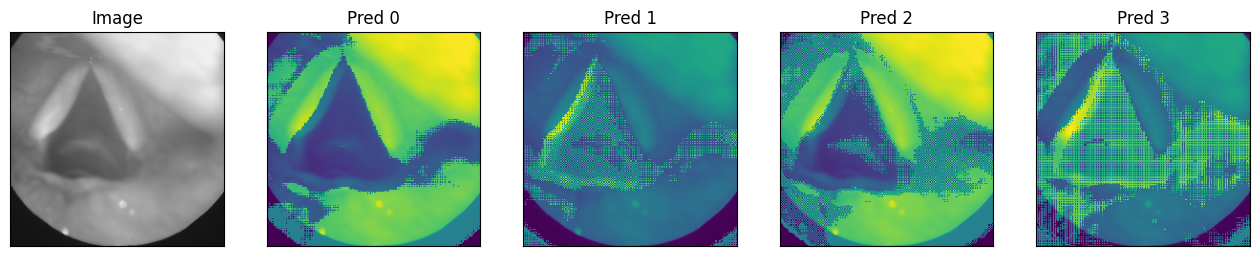

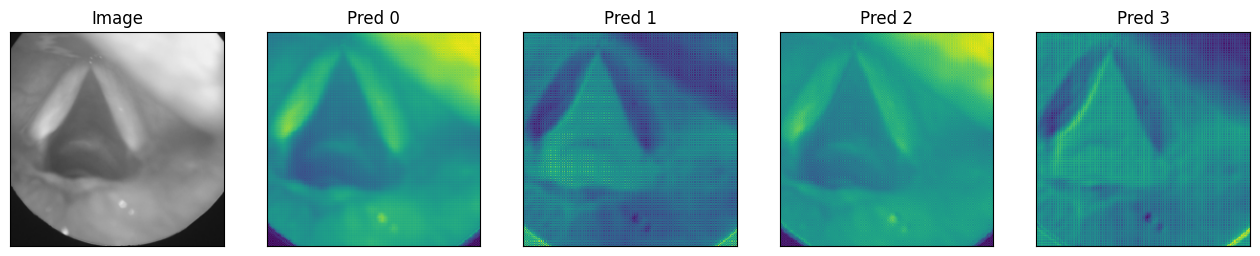

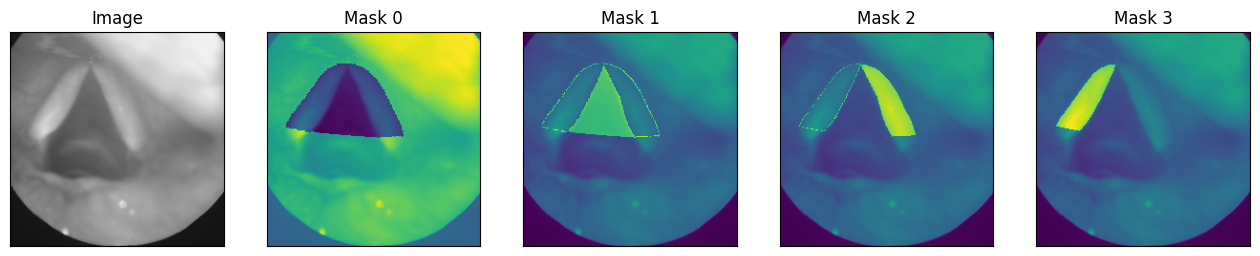

In [44]:
yasai_show_v2(train_data, 5, model.to('cpu'))

## Eval

In [27]:
def plot_predictions(model, idx, transforms):
    img = Image.open(test_df['images'].iloc[idx]).convert('RGB')
    mask = Image.open(test_df['masks'].iloc[idx])
    
    tensor_img = transforms(img)
    tensor_img = tensor_img.unsqueeze(0).to(device)
    
    model.eval()
    
    with torch.no_grad():
        pred = model(tensor_img)[0].detach().cpu().numpy()
        pred = pred.transpose((1,2,0)).squeeze()
        print(np.max(pred))
        rounded = np.round(pred)

    
        
    plot_images = {
        'Image': img,
        'Mask': mask,
        'Predicted Mask': pred,
        'Predicted Rounded Mask':rounded
    }
    
    fig, ax = plt.subplots(1, 4, figsize=(16,4))
    for i, key in enumerate(plot_images.keys()):
        ax[i].imshow(plot_images[key])
        ax[i].set_title(key)
        
    plt.show()

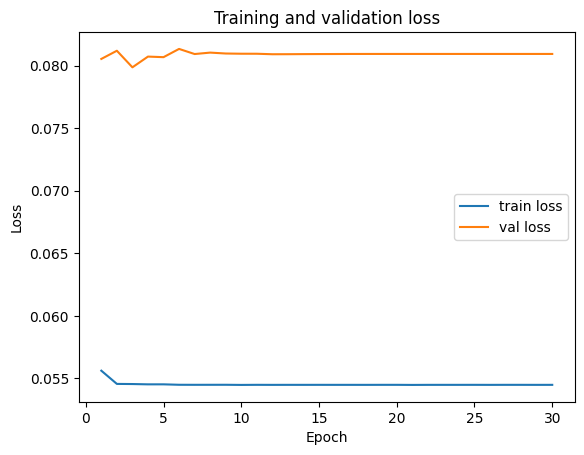

In [28]:
plt.plot(np.arange(1, epochs + 1), train_loss_list, label="train loss")
plt.plot(np.arange(1, epochs + 1), val_loss_list, label="val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and validation loss")
plt.show()

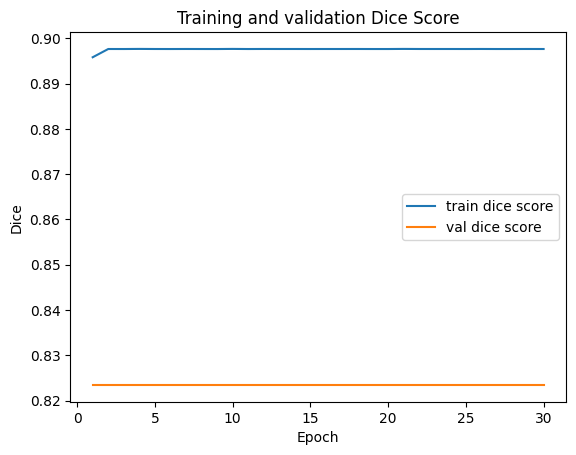

In [29]:
plt.plot(np.arange(1, epochs + 1), train_dice_coef, label="train dice score")
plt.plot(np.arange(1, epochs + 1), val_dice_coef, label="val dice score")
plt.xlabel("Epoch")
plt.ylabel("Dice")
plt.legend()
plt.title("Training and validation Dice Score")
plt.show()

0.69212055


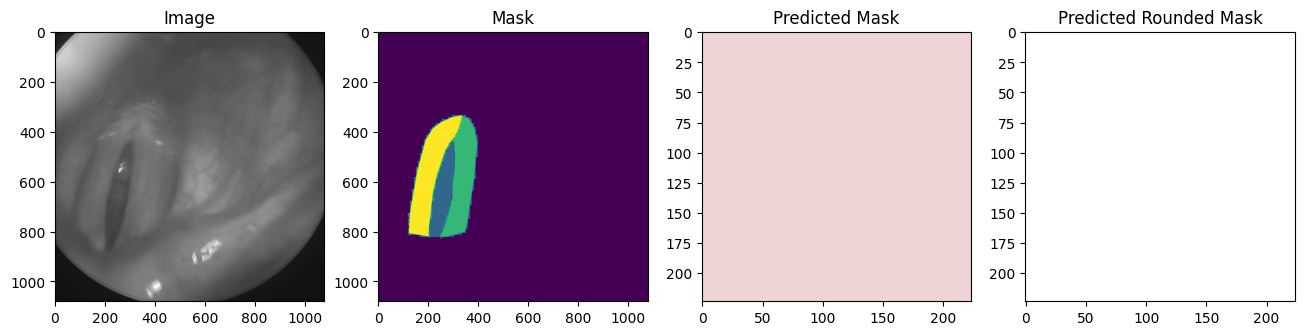

0.69212055


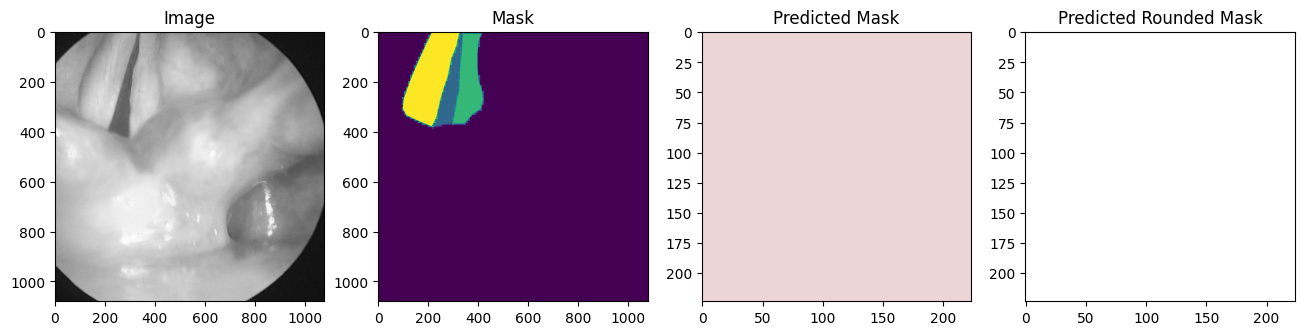

0.69212055


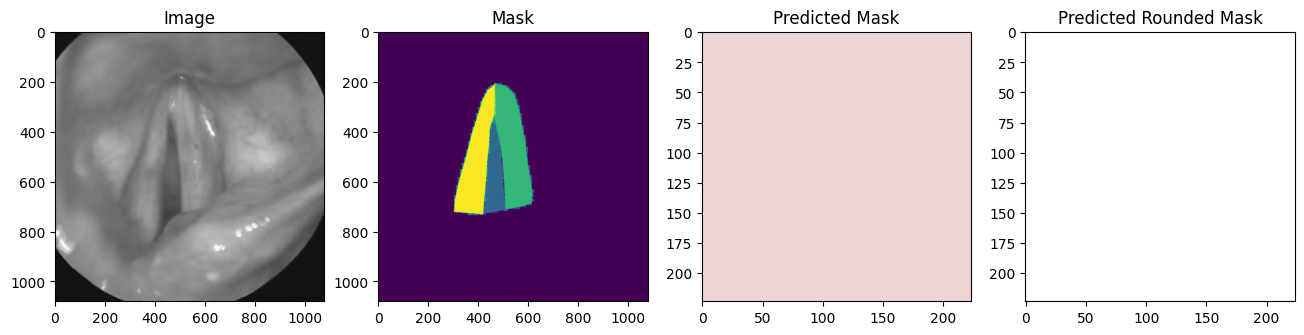

0.69212055


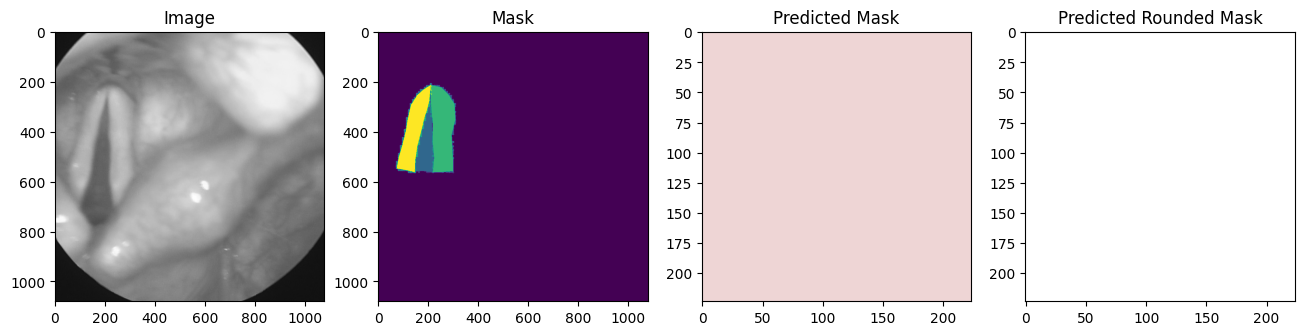

In [30]:
plot_predictions(model, 59, transform)
plot_predictions(model, 0, transform)
plot_predictions(model, 26, transform)
plot_predictions(model, 3, transform)